In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
mep = pd.read_csv('retweets.csv')

In [ ]:
mep.shape

In [ ]:
mep.columns

Delete the records with not English languages

In [ ]:
mep.lang

In [ ]:
mep = mep.loc[mep.lang == 'en']

In [ ]:
import tweepy
auth = tweepy.OAuthHandler('hsaHW0P7kFtP7yiOTWV6E5Cmz', 'A1fgwDsjBQ48dYM8xHqq1fafs8sJpOAj9m9QFkEmqBjorpEk4X')

In [ ]:
mep

In [ ]:
origTweetList = mep.origTweetId.tolist()

In [ ]:
try:
    redirect_url = auth.get_authorization_url()
except tweepy.TweepError:
    print('Error! Failed to get request token.')

In [ ]:
# api = tweepy.API(auth)
# origText = []
# for tweetid in origTweetList:
#     try:
#         tweet = api.get_status(tweetid)
#         origText.append(tweet.text)
#         print(tweet.text)
#     except:
#         origText.append('')
#         print(' ')

https://stackoverflow.com/questions/44581647/retrieving-a-list-of-tweets-using-tweet-id-in-tweepy

In [ ]:
import tweepy

import time

t0 = time.time()

def lookup_tweets(tweet_IDs, api):
    full_tweets = []
    tweet_count = len(tweet_IDs)
    try:
        for i in range((tweet_count // 100) + 1):
            # Catch the last group if it is less than 100 tweets
            end_loc = min((i + 1) * 100, tweet_count)
            full_tweets.extend(
                api.statuses_lookup(id_=tweet_IDs[i * 100:end_loc])
            )  
        return full_tweets
    except tweepy.TweepError:
        print('Something went wrong, quitting...')

auth = tweepy.OAuthHandler('hsaHW0P7kFtP7yiOTWV6E5Cmz', 'A1fgwDsjBQ48dYM8xHqq1fafs8sJpOAj9m9QFkEmqBjorpEk4X')

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# do whatever it is to get por.TweetID - the list of all IDs to look up

results = lookup_tweets(origTweetList, api)

final_dic = {}

t1 = time.time()
total = t1-t0
print(total)

In [ ]:
for tweet in results:
    if tweet:
        final_dic[tweet.id] = tweet.text

In [ ]:
import pprint
# pprint.pprint(final_dic)
len(final_dic)

In [ ]:
tweet_text = pd.DataFrame.from_dict(final_dic, orient='index', columns=['tweetText'])

## Cross Validate that the number of rows is **10126**

### Something to investigate: Do we have duplicate tweets on the dataset?
### mep rows: 13796
### mep.origTweetId.unique(): 10834

In [ ]:
len(mep.origTweetId.unique())

In [ ]:
tweet_text

In [ ]:
mepExt = pd.merge(mep, tweet_text, left_on='origTweetId', right_index=True, how='inner')

In [ ]:
group = mepExt.groupby('origMepGroupShort').count()
groupFiltered = group.loc[group.origUserId > 50]
mepExt = mepExt.loc[mepExt.origMepGroupShort.isin(list(groupFiltered.index))]

In [ ]:
mepExt

In [ ]:
export = mepExt.to_csv(r'C:\Users\Ion\Documents\GitHub\Clustering-and-Classification-of-MEPs-Tweets\fullRetweets.csv',  index = None, header=True)

## Finish the clearing part -- Exporting the CSV so I don't need to run the proccess over and over again

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_columns", 30)
%matplotlib inline

In [56]:
fullRetweets = pd.read_csv('FullRetweets.csv')

In [57]:
fullRetweets

,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,retweetMepId,retweetMepName,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang,tweetText
0,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed Jul 04 11:05:03 +0000 2012,220473289259233285,Sun Dec 07 21:46:00 +0000 2014,541710240014942209,en,Euro Parliament votes overwhelmingly to reject...
1,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,1668992125,NathanGillMEP,124965,Nathan GILL,6,EFDD,27,GBR,Fri Jul 05 08:00:23 +0000 2013,353060776707235841,Thu Jun 18 08:52:51 +0000 2015,611456527409524736,en,"US have one currency, one Central Bank and one..."
2,17675072,MartinSchulz,1911,Martin SCHULZ,1,S&D,10,DEU,21648649,maritaulvskog,96672,Marita ULVSKOG,1,S&D,26,SWE,Sat May 17 12:47:17 +0000 2014,467647542378123264,Wed Sep 16 09:15:06 +0000 2015,644077036022165504,en,More jobs for young people is my top priority ...
3,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,121171051,MargotLJParker,124945,Margot PARKER,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Thu Dec 04 22:21:10 +0000 2014,540631925145493504,en,"Vote #Labour, get Tory. Vote Tory, get Labour...."
4,744743599,Tim_Aker,99650,Tim AKER,6,EFDD,27,GBR,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,Wed May 28 16:47:44 +0000 2014,471694322472353793,Sun Mar 29 18:53:32 +0000 2015,582254277122473984,en,"Vote #Labour, get Tory. Vote Tory, get Labour...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12903,1485429175,JSaryuszWolski,28297,Jacek SARYUSZ-WOLSKI,4,EPP,20,POL,539156512,ZdzKrasnodebski,124891,Zdzisław KRASNODĘBSKI,5,ECR,20,POL,Sun Jan 24 13:17:25 +0000 2016,691248438504210432,Mon Jan 25 08:21:14 +0000 2016,691536290198745088,en,Drastic drop in positive EU perception in Pola...
12904,829060856,TheresaMEP,124961,Theresa GRIFFIN,1,S&D,27,GBR,1354570123,julie4nw,124963,Julie WARD,1,S&D,27,GBR,Sun Jan 24 14:04:13 +0000 2016,691260217288454144,Sun Jan 24 14:54:31 +0000 2016,691272874393485314,en,I'm with @UKYP North West now in Knowsley - gr...
12905,829060856,TheresaMEP,124961,Theresa GRIFFIN,1,S&D,27,GBR,202610289,akhanmep,124962,Afzal KHAN,1,S&D,27,GBR,Sun Jan 24 14:12:29 +0000 2016,691262296396599296,Sun Jan 24 14:21:13 +0000 2016,691264493725335552,en,Listening to some fab ideas from young people ...
12906,829060856,TheresaMEP,124961,Theresa GRIFFIN,1,S&D,27,GBR,1354570123,julie4nw,124963,Julie WARD,1,S&D,27,GBR,Sun Jan 24 14:12:29 +0000 2016,691262296396599296,Sun Jan 24 14:54:26 +0000 2016,691272856739659776,en,Listening to some fab ideas from young people ...


## Remember to do something with word clouds

In [3]:
import wordcloud
import matplotlib
import PIL

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

# another set of stopwords

from nltk.corpus import stopwords
import nltk
import sklearn as sk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
clean_text = fullRetweets.tweetText.drop_duplicates()

In [8]:
corpus = list(clean_text)

In [113]:
corpus

['Euro Parliament votes overwhelmingly to reject #ACTA but the Commission say they still intend to press ahead. Another reason to vote @UKIP',
 'US have one currency, one Central Bank and one Govt. Europe has one currency, one Central Bank and...17 govts! Cannot go on like this.',
 'More jobs for young people is my top priority for the EU @socialdemocraterna @maritaulvskog  #EP2014 in Umea Sweden http://t.co/3O6ZM5J8Nt',
 'Vote #Labour, get Tory. Vote Tory, get Labour. Vote #UKIP get UKIP  http://t.co/buStolPbTT',
 'Answering my question in ECR Group J-C Juncker has confirmed that the post of Chief Scientific Advisor will be continued in his presidency.',
 "Robert Halfon raising issue of illegal traveller sites - if UKIP had done it he'd have called us Nazis http://t.co/rBdwA6OYx8 #opportunist",
 'Ignore the Labour lies, this is where #UKIP stands on the #NHS http://t.co/a5cZurjf9n',
 "Next week I'll be grilling EU Commissioner candidates about  the environment. What would you ask? #As

In [141]:
from sklearn.feature_extraction import text 

my_additional_stop_words = ['http', 'https', 'amp']

stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

* Lowercase
* min_df - max_df
* stop_words

In [142]:
my_stop_words = set(stopwords.words('english')) 
vectorizer = CountVectorizer(lowercase=True, min_df=10, max_df=0.5, stop_words =stop_words)
X = vectorizer.fit_transform(corpus)
X.shape
# vectorizer2 = TfidfVectorizer(lowercase=True, min_df=10, max_df=0.5, stop_words='english')
# X2 = vectorizer2.fit_transform(corpus)

(10102, 1947)

In [143]:
vectorizer.get_feature_names()

['00',
 '000',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '1st',
 '20',
 '2010',
 '2012',
 '2014',
 '2015',
 '2016',
 '2017',
 '2020',
 '22',
 '24',
 '25',
 '27',
 '28',
 '2nd',
 '30',
 '3bn',
 '3rd',
 '40',
 '45',
 '50',
 '70',
 '75',
 '80',
 'able',
 'abroad',
 'absolutely',
 'abuse',
 'accept',
 'accepted',
 'access',
 'according',
 'account',
 'achieve',
 'act',
 'action',
 'actions',
 'activists',
 'actually',
 'address',
 'addressing',
 'admits',
 'adopted',
 'advice',
 'affairs',
 'affected',
 'africa',
 'african',
 'afternoon',
 'age',
 'agenda',
 'ago',
 'agree',
 'agreed',
 'agreement',
 'agreements',
 'agrees',
 'agriculture',
 'ahead',
 'aid',
 'air',
 'akhanmep',
 'al',
 'alan',
 'alde',
 'aldecongress',
 'aldegroup',
 'aldeparty',
 'allianceecr',
 'allow',
 'allowed',
 'allowing',
 'alongside',
 'alternative',
 'amazing',
 'ambassador',
 'ambition',
 'ambitious',
 'amendment',
 'amendments',
 'american',
 'anagomesmep',
 'analysis',
 'a

In [144]:
kmeans = KMeans(n_clusters=6).fit(X)

In [145]:
cluster_labels = kmeans.fit_predict(X)

In [146]:
metrics.silhouette_score(X, labels=cluster_labels)

0.025111060817909057

In [147]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer2.get_feature_names()
for i in range(6):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :15]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: tweet timmermans kurdish visit partner new peace imf poland juncker tv tonoepp know grand elected
Cluster 1: working week timmermans davidmartinmep epp europarl_en netherlands wonderful grand aldegroup environment gone reforms ne ecr
Cluster 2: etuc_ces tv leaderslive came timmermans ne record bringing membership tourism sun europarl_en peace poland meetings
Cluster 3: europe paris understand growth deaths juncker epp timmermans etuc_ces trying ne europarl_en comments netherlands grand
Cluster 4: visit etuc_ces trying membership timmermans environment kurdish wwii deaths eurogroup tweet peace ireland renegotiation main
Cluster 5: timmermans europarl_en epp environment grand gone peace media netherlands trying europarl ne sun greater membership


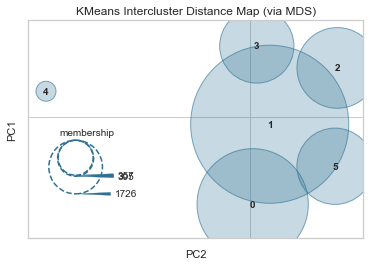

In [148]:
model = KMeans(6)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

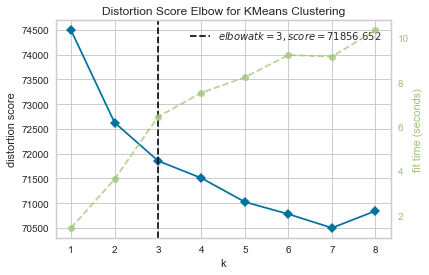

In [149]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,9))

visualizer.fit(X)
visualizer.show()

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

plt.figure(figsize=(4 * 4,  2 * 8))

scores = {}
for n_clusters in range(2, 10):
    plt.subplot(4, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')